<xarray.Dataset>
Dimensions:    (bound: 2, lat: 360, level: 25, lon: 720, time: 12)
Coordinates:
  * lon        (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat        (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time       (time) object 2014-01-16 00:00:00 ... 2014-12-16 00:00:00
  * level      (level) float64 0.305 0.915 1.525 2.135 ... 13.72 14.33 14.95
Dimensions without coordinates: bound
Data variables:
    lat_bnds   (lat, bound) float64 ...
    lon_bnds   (lon, bound) float64 ...
    time_bnds  (time, bound) object ...
    emis_tot   (time, lat, lon, level) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    institution_id:              PNNL-JGCRI
    activity_id:                 input4MIPs
    Conventions:                 CF-1.6
    creation_date:               2016-08-26T14:58:46Z
    data_structure:              grid
    frequency:                   mon
    realm:                       atmos
    source:                      C

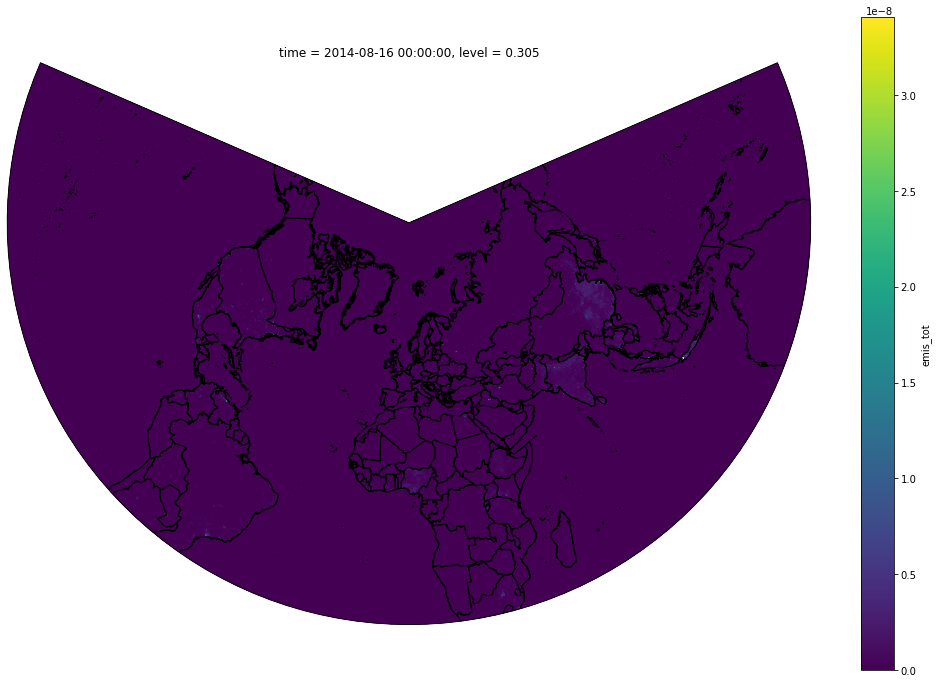

In [32]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader
from cartopy.io.shapereader import Reader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import (OCEAN, LAKES, BORDERS, COASTLINE, RIVERS, COLORS,
                             LAND)
#import netcdf4

ds = xr.open_dataset('F:/historic_emissions/CO-em-anthro_input4MIPs_emissions_CMIP_CEDS-v2016-07-26-sectorDim_gn_200001-201412.nc')
air_ds = xr.open_dataset('F:/historic_emissions/CO-em-AIR-anthro_input4MIPs_emissions_CMIP_CEDS-2017-08-30_gn_200001-201412.nc')

#print(ds['time'])

relev_ds = ds.sel(time=slice("2014-01-01","2014-12-16")) #extract 2014 emissions from anthro database
relev_air_ds =air_ds.sel(time=slice("2014-01-01", "2014-12-16")) #getting rid of level as I don't think WRF-Chem does anything useful with it

#this section separates the sectors as individual arrays

emis_agr = relev_ds.isel(sector=0).reset_coords("sector")
emis_agr['emis_agr'] = emis_agr['CO_em_anthro']+0 #adding +0 because otherwise I think dropping CO_em_anthro turns everything into NaN
emis_agr = emis_agr.drop_vars('CO_em_anthro')
emis_agr =emis_agr.drop_vars('sector') #no idea why it won't let me drop both simultaneously, but it won't
emis_agr = emis_agr.drop_vars('sector_bnds')
emis_ene = relev_ds.isel(sector=1).reset_coords("sector")
emis_ene['emis_ene'] = emis_ene['CO_em_anthro']+0
emis_ene = emis_ene.drop_vars('CO_em_anthro')
emis_ene = emis_ene.drop_vars('sector')
emis_ene = emis_ene.drop_vars('sector_bnds')
emis_ind = relev_ds.isel(sector=2).reset_coords("sector") 
solvent = relev_ds.isel(sector=5).reset_coords("sector") #combined based on EDGAR-HTAP2 method
emis_tra = relev_ds.isel(sector=3).reset_coords("sector")
emis_tra['emis_tra'] = emis_tra['CO_em_anthro']+0
emis_tra = emis_tra.drop_vars('CO_em_anthro')
emis_tra = emis_tra.drop_vars('sector')
emis_tra = emis_tra.drop_vars('sector_bnds')
emis_res = relev_ds.sel(sector=4).reset_coords("sector")
waste = relev_ds.sel(sector=6).reset_coords("sector") #combined based on EDGAR-HATP2 method
emis_shp = relev_ds.isel(sector=7).reset_coords("sector")
emis_shp['emis_shp'] = emis_shp['CO_em_anthro']+0
emis_shp = emis_shp.drop_vars('CO_em_anthro')
emis_shp = emis_shp.drop_vars('sector')
emis_shp = emis_shp.drop_vars('sector_bnds')

#do aircraft separately from different file

emis_air = relev_air_ds
emis_air['emis_air'] = emis_air['CO_em_AIR_anthro']+0  #aircraft emissions aren't split by sector
#emis_air = emis_air.drop_vars('level')
#emis_air = emis_air.squeeze('level')
emis_air = emis_air.drop_vars('CO_em_AIR_anthro')
#test this section
#print (emis_shp) #just to compare variables

#this next bit combines some sectors in the CMIP emissions 


emis_ind['emis_ind'] =emis_ind['CO_em_anthro'] + solvent['CO_em_anthro']
emis_ind = emis_ind.drop_vars('CO_em_anthro')
emis_ind = emis_ind.drop_vars('sector')
emis_ind = emis_ind.drop_vars('sector_bnds')
emis_res['emis_res'] =emis_res['CO_em_anthro'] + waste['CO_em_anthro']
emis_res = emis_res.drop_vars('CO_em_anthro')
emis_res = emis_res.drop_vars('sector')
emis_res = emis_res.drop_vars('sector_bnds')


#use the same method for total emissions

emis_tot = relev_ds.isel(sector=0).reset_coords("sector",drop=True)
emis_tot['emis_tot'] = emis_agr['emis_agr']+emis_ene['emis_ene']+emis_tra['emis_tra']+emis_shp['emis_shp']+emis_ind['emis_ind']+emis_res['emis_res'] +emis_air['emis_air']
emis_tot = emis_tot.drop_vars('CO_em_anthro')
emis_tot = emis_tot.drop_vars('sector_bnds')

print (emis_tot)

#just reading this in for a test plot. Hash out if you know the code works as it makes it slow
statesetc = shpreader.natural_earth(resolution='10m',# downloads country borders from Natural Earth
                                      category='cultural',
                                      name='admin_0_countries') #
shape_feature_another = ShapelyFeature(Reader(statesetc).geometries(),
                                ccrs.PlateCarree(), edgecolor='black', facecolor = 'none') #setting the facecolor as none is important, otherwise you can't see what is being plotted


#lon = relev_ds['lon']
#lat = relev_ds['lat']
#time = relev_ds['time']


#merge the arrays to form one new dataset

merge1 = emis_agr.merge(emis_ene)
merge2 = merge1.merge(emis_ind)
merge3 = merge2.merge(emis_tra)
merge4 = merge3.merge(emis_res)
merge5 = merge4.merge(emis_shp)
merge6 = merge5.merge(emis_air,compat='override') #seem to need to add this override because of incompatible lat/lon bounds. I don't know if this'll cause any issues
final_file = merge6.merge(emis_tot)

#plot and print to check output

print(final_file)
to_plot = final_file['emis_tot'].isel(time=7,level=0)
#test = relev_ds.reset_coords(names="sector")


fig = plt.figure (figsize = (18, 12))
ax =plt.axes(projection = ccrs.LambertConformal(central_longitude =5.4)) 
ax.coastlines()

#ax.set_extent([-10.5,2.9,49,61]) #Doesn't seem to show the UK with much definition

ax.add_feature(shape_feature_another) 
to_plot.plot(transform=ccrs.PlateCarree())
plt.show()







#print (relev_ds['sector'])
#print(emis_agr)

#relev_ds['sector'][0].rename("emis_agr")
#print(relev_ds)